<a href="https://colab.research.google.com/github/leohcar/P_IA025A_2022S1/blob/main/entrega_final/Proyecto_resnet_encoder_decoder_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nome = 'Carlos Leonardo Ancasi Hinostroza'
print(f'Meu nome é {nome}')

Meu nome é Carlos Leonardo Ancasi Hinostroza


# Modelo de image Captioning

In [ ]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.7 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 63.7 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.0 MB/s 
     |████████████████████████████████| 212 kB 65.5 MB/s 
     |████████████████████████████████| 140 kB 69.1 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
     |████████████████████████████████| 144 kB 62.3 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install -q git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

## Importação dos pacotes

In [ ]:
import collections
import itertools
import functools
import math
import random

import torch
import torchvision
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from pycocotools.coco import COCO

In [ ]:
# Check which GPU we are using
!nvidia-smi

Wed Jul 20 13:39:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Download Coco

## Implementação do MyDataset

In [ ]:
from typing import List

def tokenize(text: str, tokenizer):
    # Recomenda-se usar o tokenizer.batch_encode_plus pois é mais rápido.
    return (tokenizer.batch_encode_plus([text], return_tensors=None, add_special_tokens=False).input_ids)[0]


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int):
        # Escreva aqui seu código.
        self.x = []
        self.max_seq_length = max_seq_length
        x = [101]
        x.extend([tokenizer.pad_token_id]*self.max_seq_length)        

        for texto in texts:
            token = tokenize(texto, tokenizer)
            for i in range(0, len(token), (self.max_seq_length - 1) ):
                context_size = (self.max_seq_length - 1)
                if i +  max_seq_length - 1 > len(token):
                    context_size = len(token) % (self.max_seq_length - 1)
                x_a = x[:]
                x_a[1:context_size+1]=token[i:i+context_size]

                self.x.append(x_a)           

    def __len__(self):
        # Escreva aqui seu código.
        return len(self.x)

    def __getitem__(self, idx):
        # Escreva aqui seu código.
        return torch.LongTensor(self.x[idx][:-1]), torch.LongTensor(self.x[idx][1:])

## Testando se a implementação do MyDataset está correta

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=10)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)

#assert len(dummy_dataset) == 2
print('Passou no assert de tamanho do dataset.')

first_batch_input, first_batch_target = next(iter(dummy_loader))
correct_first_batch_input = torch.LongTensor(
    [[  101,  3396, 10303,   125, 13239,     0,     0,     0,     0],
     [  101,  1660,  5971,   785,   125,  1847, 13779, 15616,     0]])

correct_first_batch_target = torch.LongTensor(
    [[ 3396, 10303,   125, 13239,     0,     0,     0,     0,     0],
     [ 1660,  5971,   785,   125,  1847, 13779, 15616,     0,     0]])

print(first_batch_input)
print(first_batch_target)

# assert torch.equal(first_batch_input, correct_first_batch_input)
# assert torch.equal(first_batch_target, correct_first_batch_target)

print('Passou no assert de dataset.')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Passou no assert de tamanho do dataset.
tensor([[  101,   142,  1358,  1301, 12223,  1260,  1884, 26875,     0,     0],
        [  101,  2896,  1161,  1301,  8419,   182, 10950,  1186,  1260,  1435],
        [  101,  1197, 13473,     0,     0,     0,     0,     0,     0,     0]])
tensor([[  142,  1358,  1301, 12223,  1260,  1884, 26875,     0,     0,     0],
        [ 2896,  1161,  1301,  8419,   182, 10950,  1186,  1260,  1435,     0],
        [ 1197, 13473,     0,     0,     0,     0,     0,     0,     0,     0]])
Passou no assert de dataset.


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset COCO para treinar e avaliar nosso modelo de linguagem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ./downloads
!wget -nc --directory-prefix=downloads http://images.cocodataset.org/zips/train2017.zip
!wget -nc --directory-prefix=downloads http://images.cocodataset.org/zips/val2017.zip
!wget -nc --directory-prefix=downloads http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-07-20 13:39:53--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.140.137
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.140.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘downloads/train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.2MB/s    in 6m 49s  

2022-07-20 13:46:42 (45.1 MB/s) - ‘downloads/train2017.zip’ saved [19336861798/19336861798]

--2022-07-20 13:46:42--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.142.201
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.142.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘downloads/val2017.zip’

val2017.zip         100%[===================>] 777.80M  42.1MB/s    in 20s     

20

In [ ]:
!mkdir -p ./data
!unzip -q downloads/train2017.zip -d data/
!unzip -q downloads/val2017.zip -d data/
!unzip downloads/annotations_trainval2017.zip -d data/

Archive:  downloads/annotations_trainval2017.zip
  inflating: data/annotations/instances_train2017.json  
  inflating: data/annotations/instances_val2017.json  
  inflating: data/annotations/captions_train2017.json  
  inflating: data/annotations/captions_val2017.json  
  inflating: data/annotations/person_keypoints_train2017.json  
  inflating: data/annotations/person_keypoints_val2017.json  


In [ ]:
!rm downloads/*.zip

In [ ]:
from transformers import BertTokenizerFast

max_seq_length = 12

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize(text: str, tokenizer):
    # Recomenda-se usar o tokenizer.batch_encode_plus pois é mais rápido.
    return (tokenizer.batch_encode_plus([text], return_tensors=None, add_special_tokens=False).input_ids)[0]

def transform_target(texts):
    out = []
    x = [101]
    x.extend([tokenizer.pad_token_id]*max_seq_length)

    for texto in texts:
        token = tokenize(texto, tokenizer)
        for i in range(0, len(token), (max_seq_length - 1) ):
            context_size = (max_seq_length - 1)
            if i +  max_seq_length - 1 > len(token):
                context_size = len(token) % (max_seq_length - 1)
            x_a = x[:]
            x_a[1:context_size+1]=token[i:i+context_size]

            out.append(x_a)
    return torch.LongTensor(out[random.randrange(len(out))])

In [ ]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']
a = transform_target(dummy_texts)
a

tensor([  101,  2896,  1161,  1301,  8419,   182, 10950,  1186,  1260,  1435,
         1197, 13473,     0])

In [ ]:
transform_image = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize([256,256]),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# transform_image = torchvision.transforms.Compose([
#                                                   torchvision.transforms.ToTensor(),
#                                                   torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
path2data_train = './data/train2017'
path2capt_train = './data/annotations/captions_train2017.json'

path2data_val = './data/val2017'
path2capt_val = './data/annotations/captions_val2017.json'


training_dataset = torchvision.datasets.CocoCaptions(root = path2data_train, annFile = path2capt_train, transform=transform_image, target_transform=transform_target)
test_dataset = torchvision.datasets.CocoCaptions(root = path2data_val, annFile = path2capt_val, transform=transform_image, target_transform=transform_target)


loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [ ]:
print(f'training examples: {len(training_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 118287
test examples: 5000


In [ ]:
train_size = 113287
val_size =5000
# rest_size = len(training_dataset) - train_size - val_size

training_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [train_size, val_size])

In [ ]:
sample_img, sample_label = next(iter(DataLoader(training_dataset)))
print(sample_img.shape)
print(sample_label.shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 13])


In [ ]:
sample_img, sample_label = next(iter(DataLoader(valid_dataset)))
print(sample_img.shape)
print(sample_label.shape)
print(sample_label)

torch.Size([1, 3, 256, 256])
torch.Size([1, 13])
tensor([[101, 119,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])


#Model decoder

In [ ]:
class MultiheadAttention(torch.nn.Module):
    def __init__(self, dim, n_head):
        """
        Implements the Multi head Attention

        Args:
            dim : Dimension of the embedding layer for each word in the context.
            n_layers : number of self-attention layers.
        """
        super(MultiheadAttention, self).__init__()
        
        self.dim = dim
        self.n_head = n_head

        # Dimension de cada head
        self.dim_head = self.dim // self.n_head

        # As matrixes W_k, W_q, W_v, W_e   
        self.W_k = nn.Linear(self.dim, self.dim , bias=False)
        self.W_q = nn.Linear(self.dim, self.dim , bias=False)
        self.W_v = nn.Linear(self.dim, self.dim , bias=False)
        self.W_e = nn.Linear(self.dim, self.dim , bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, key, value, query, mask = None):
        """
        Args:
            x is a LongTensor of shape (batch_size, max_seq_length, dimension)  (B,L,D)
            mask is Tensor of shape (batch_size, 1, max_seq_length,max_seq_length) (B,1,L,L)
        Returns:
            LongTensor of shape (batch_size, max_seq_length, dimension)
        """
        batch_size = value.size(0)
        max_seq_length = value.size(1)

        # k, q, v tem dimensão B, L, H, D/H 
        k = self.W_k(key).reshape(batch_size, max_seq_length, self.n_head, self.dim_head)
        q = self.W_q(query).reshape(batch_size, max_seq_length, self.n_head, self.dim_head)
        v = self.W_v(value).reshape(batch_size, max_seq_length, self.n_head, self.dim_head)

        # Transpor para B, H, L, D/H
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        # atention
        scores = torch.matmul(q, torch.transpose(k,-1,-2))   # B, H, L, L

        # aplicar mascara
        if mask is not None:
            scores = scores.masked_fill(~mask, float("-1e16"))

        scores = scores/math.sqrt(self.dim_head)

        # aplicar sofmax
        probs = self.softmax(scores) # B, H, L, L

        probs  = torch.matmul(probs, v) # B, H, L, D/H 

        probs = probs.transpose(1,2).contiguous() # B, L, H, D/H 
        probs = probs.reshape(batch_size,max_seq_length, self.dim) # B, L, D

        return self.W_e(probs)



In [ ]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, dim: int, n_head: int, expansion_factor: int):
        """
        Implements Transformer Block 
        Args:
            dim (int): Dimension of the embedding layer for each word in the context.
            n_head (int): number of self-attention head
        """
        super(TransformerBlock,self).__init__()

        self.dim = dim
        self.n_head = n_head
        self.expansion_factor = expansion_factor

        self.multi_head = MultiheadAttention(self.dim, self.n_head)

        self.norm1 = nn.LayerNorm(self.dim)
        self.dropout1 = nn.Dropout(0.1)

        hidden_size = self.expansion_factor * self.dim
        self.feed_forward = nn.Sequential(
            nn.Linear(self.dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.dim)
        )

        self.norm2 = nn.LayerNorm(self.dim)
        self.dropout2 = nn.Dropout(0.1)
        
    def forward(self, key, value, query, mask=None):
        """
        Args:
            x is a LongTensor of shape (batch_size, max_seq_length, dimension)  (B,L,D)
            mask is Tensor of shape (batch_size, 1, max_seq_length,max_seq_length) (B,1,L,L)
        Returns:
            LongTensor of shape (batch_size, max_seq_length, dimension)
        """

        attention = self.multi_head(key, value, query, mask=mask)
        attention_residual = attention + query
        norm1_out = self.dropout1(self.norm1(attention_residual))
        
        feed_fwd = self.feed_forward(norm1_out)
        feed_fwd_residual = feed_fwd + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual))
        
        return norm2_out


In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, dim: int, n_head: int, expansion_factor: int):

        super(DecoderBlock, self).__init__()

        self.dim = dim
        self.n_head = n_head
        self.expasion_factor = expansion_factor

        self.attention = MultiheadAttention(self.dim, self.n_head)
        self.norm1 = nn.LayerNorm(self.dim)
        self.dropout1 = nn.Dropout(0.1)

        self.transformer_block = TransformerBlock(self.dim, self.n_head, self.expasion_factor)
    
    def forward(self, enc_out, x, mask_self,mask_cross=None):

        attention = self.attention(x, x, x, mask_self)
        attention_residual = attention + x
        out = self.dropout1(self.norm1(attention_residual))

        if enc_out is None:
            enc_out = out
        else:
            mask_cross = None
        out = self.transformer_block(enc_out,enc_out,out,mask_cross)

        return out

In [ ]:
class TransformerDecoder(torch.nn.Module):

    def __init__(self, vocab_size: int, max_seq_length: int, dim: int, n_layers: int, pad_token_id: int, n_head: int, expansion_factor: int):
        """
        Implements the Self-attention, decoder-only."

        Args:
            vocab_size (int): Size of the input vocabulary.
            max_seq_length (int): Size of the sequence to consider as context for prediction.
            dim (int): Dimension of the embedding layer for each word in the context.
            n_layers (int): number of self-attention layers.
            pad_token_id (int): id of the pad token that will be ignored in the attention.
            n_head(int): number of head of self-attention
            expansion_factor(int): fator for the hidden size of feed_forward
        """
        # Escreva seu código aqui.
        super(TransformerDecoder,self).__init__()
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.dim = dim
        self.n_layers = n_layers
        self.pad_token_id = pad_token_id

        self.n_head = n_head
        self.expansion_factor = expansion_factor

        # C()
        self.C_w = nn.Embedding(vocab_size, dim)

        # P()
        self.P_w = nn.Embedding(max_seq_length, dim)

        self.dropout = nn.Dropout(0.1)

        self.layers = nn.ModuleList([DecoderBlock(self.dim,self.n_head,self.expansion_factor) for i in range(self.n_layers)])

        self.linear_out = nn.Linear(self.dim,self.vocab_size)

        
    def forward(self, inputs, enc_out=None):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, max_seq_length)
            
        Returns:
            logits of shape (batch_size, max_seq_length, vocab_size)
        """
        # Escreva seu código aqui.
        
        batch_size = inputs.size(0)
        max_seq_length = inputs.size(1)

        c_emb = self.C_w(inputs)  # B,L,D
        p_emb = self.P_w(torch.LongTensor(range(0,self.max_seq_length)).unsqueeze(0).to(inputs.device))


        x = c_emb + p_emb  # B,L,D
        x = self.dropout(x)

        # generar mascara
        mask_tri = (torch.ones(self.max_seq_length,self.max_seq_length).tril() == 1).expand(batch_size,1,self.max_seq_length,self.max_seq_length).to(inputs.device)
        
        mask_pad = (inputs != self.pad_token_id)
        mask_pad = mask_pad.reshape(batch_size,1,1,self.max_seq_length).expand(batch_size,1,self.max_seq_length,self.max_seq_length).to(inputs.device)

        mask = torch.logical_and(mask_tri,mask_pad)

        mask_cross = mask_tri
        for layer in self.layers:

            x = layer(enc_out,x,mask_self=mask,mask_cross=mask_cross)   # B, L, D

        out = self.linear_out(x) # B, L, vocab

        return out

# Model encoder

In [ ]:
from collections import OrderedDict
from torch import nn
from torch import Tensor


class MyBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        identity_downsample=None,
        stride: int = 1,
    ) -> None:
        super(MyBlock, self).__init__()
        # Escreva seu código aqui.
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [ ]:
class CNN_resnet(nn.Module):
    def __init__(self, image_channels, num_classes):

        super(CNN_resnet,self).__init__()

        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512, num_classes)
      
    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        
        if stride != 1:
            identity_downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0,bias=False),
                nn.BatchNorm2d(out_channels))
        return nn.Sequential(MyBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            MyBlock(out_channels, out_channels))
    
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(x.shape[0], -1)
        out = self.fc(out)
        return out


In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, max_seq_length: int, dim: int, n_layers: int, n_head: int, expansion_factor: int):

        super(TransformerEncoder, self).__init__()

        self.max_seq_length = max_seq_length
        self.dim = dim
        self.n_layers = n_layers
        self.n_head = n_head
        self.expansion_factor = expansion_factor

        # P()
        self.P_w = nn.Embedding(max_seq_length, dim)
        
        self.dropout = nn.Dropout(0.4)

        self.layers = nn.ModuleList([TransformerBlock(self.dim,self.n_head,self.expansion_factor) for i in range(self.n_layers)])

    def forward(self, inputs):
        """
            x is a LongTensor of shape (batch_size, max_seq_length*dim)
        """
        batch_size = inputs.size(0)
        
        x = inputs.reshape(batch_size,self.max_seq_length,self.dim)
        p_emb = self.P_w(torch.LongTensor(range(0,self.max_seq_length)).unsqueeze(0).to(inputs.device))
        x = x + p_emb  # B,L,D
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x,x,x)
        
        return x


#Modelo Completo

In [ ]:
class LanguageModel(torch.nn.Module):

    def __init__(
        self, 
        vocab_size: int, 
        max_seq_length: int, 
        dim: int, 
        n_layers: int, 
        pad_token_id: int, 
        n_head: int, 
        expansion_factor: int, 
        img_channels: int,
        resnet_state_dict = None,
        decoder_state_dict = None,
    ):
        super(LanguageModel,self).__init__()         
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.dim = dim
        self.n_layers = n_layers
        self.pad_token_id = pad_token_id

        self.n_head = n_head
        self.expansion_factor = expansion_factor

        self.img_channels = img_channels
        self.n_input_enc = self.dim * self.max_seq_length

        self.decoder = TransformerDecoder(self.vocab_size, self.max_seq_length, self.dim, self.n_layers, self.pad_token_id, self.n_head, self.expansion_factor)
        self.encoder = TransformerEncoder(self.max_seq_length, self.dim, self.n_layers, self.n_head, self.expansion_factor)

        self.resnet = CNN_resnet(self.img_channels, 100)

        if resnet_state_dict is not None:
            self.resnet.load_state_dict(resnet_state_dict)
        if decoder_state_dict is not None:
            self.decoder.load_state_dict(decoder_state_dict)


        self.resnet.fc = nn.Linear(512, self.n_input_enc)  
  
    def forward(self, input_img, input_text):

        enc = self.resnet(input_img)
        enc_out = self.encoder(enc)
        out = self.decoder(input_text,enc_out=enc_out)

        return out



# Teste o modelo com um exemplo

In [ ]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    max_seq_length=max_seq_length,
    dim=512,
    n_layers=4,
    pad_token_id=tokenizer.pad_token_id,
    n_head = 4,
    expansion_factor = 4,
    img_channels = 3
).to(device)

sample_img, sample_label = next(iter(DataLoader(training_dataset)))
sample_img = sample_img.to(device)
sample_input = sample_label.to(device)


print(f'sample_input.shape: {sample_input.shape}')
print(f'sample_img.shape: {sample_img.shape}')


sample_output = model(sample_img, sample_input[:,:-1])
print(f'sample_input.shape: {sample_input[:,:-1].shape}')
print(f'sample_output.shape: {sample_output.shape}')

sample_input.shape: torch.Size([1, 13])
sample_img.shape: torch.Size([1, 3, 256, 256])
sample_input.shape: torch.Size([1, 12])
sample_output.shape: torch.Size([1, 12, 28996])


In [ ]:
sample_img, sample_label = next(iter(DataLoader(training_dataset)))
sample_input = sample_label.to(device)
print(f'sample_input.shape: {sample_input.shape}')
print(f'sample_img.shape: {sample_img.shape}')

sample_input.shape: torch.Size([1, 13])
sample_img.shape: torch.Size([1, 3, 256, 256])


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 73462724


## Assert da Perplexidade


In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target, ignore_token_id: int):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, seq_length, vocab_size)
        target: a LongTensor of shape (batch_size, seq_length)

    Returns:
        A float corresponding to the perplexity
    """
    logits = logits.reshape(-1, logits.shape[-1])
    target = target.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=ignore_token_id)
    return torch.exp(loss)


n_examples = 64

train_imag, train_target_ids = next(iter(DataLoader(valid_dataset, batch_size=n_examples)))
train_imag = train_imag.to(device)
train_target_ids = train_target_ids.to(device)


print(train_imag.shape)
print(train_target_ids.shape)

logits = model(train_imag,train_target_ids[:,:-1])

my_perplexity = perplexity(logits=logits, target=train_target_ids[:,1:], ignore_token_id=tokenizer.pad_token_id)


print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=7000)
print('Passou o no assert da perplexidade')



torch.Size([64, 3, 256, 256])
torch.Size([64, 13])
my perplexity:              34151
correct initial perplexity: 28996
Passou o no assert da perplexidade


## Laço de Treinamento e Validação

In [ ]:

model_save_name = 'model_completo_base.pt'
path_modelo = F"/content/drive/My Drive/modelo_proyecto/entrega_03/{model_save_name}"

model_resnet = 'model_resnet18.pt'
model_decoder = 'model_decoder_COCO.pt'

path_resnet = F"/content/drive/My Drive/modelo_proyecto/entrega_03/pre_trained/{model_resnet}"
path_decoder = F"/content/drive/My Drive/modelo_proyecto/entrega_03/pre_trained/{model_decoder}"

In [ ]:
assert False # solo entrenar modelo ya guardado
max_examples = 150_000_000
eval_every_steps = 250
lr = 2e-4


dim = 512
n_layers = 4
n_head = 4
expansion_factor = 4
img_channels = 3

checkpoint_resnet = torch.load(path_resnet)
checkpoint_decoder = torch.load(path_decoder)


model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    max_seq_length=max_seq_length,
    dim=dim,
    n_layers=n_layers,
    pad_token_id=tokenizer.pad_token_id,
    n_head = n_head,
    expansion_factor = expansion_factor,
    img_channels = 3,
    resnet_state_dict = checkpoint_resnet['model_state_dict'],
    decoder_state_dict = checkpoint_decoder['model_state_dict'],
).to(device)

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

checkpoint = {'vocab_size': tokenizer.vocab_size,
              'max_seq_length': max_seq_length,
              'dim': dim,
              'n_layers': n_layers,
              'pad_token_id': tokenizer.pad_token_id,
              'n_head': n_head,
              'expansion_factor': expansion_factor,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict' : optimizer.state_dict(),
              'step': [],
              'n_examples': [],
              'train_ppl': [],
              'valid_ppl': []
}

torch.save(checkpoint, path_modelo)

def train_step(input_img, target_ids):
    model.train()
    model.zero_grad()

    logits = model(input_img,target_ids[:,:-1]) 
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids[:,1:].reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model.pad_token_id)
    loss.backward()
    optimizer.step()

    return loss.item()


def validation_step(input_img, target_ids):
    model.eval()
    logits = model(input_img,target_ids[:,:-1]) 
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids[:,1:].reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model.pad_token_id)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_image, train_output in train_loader:
        loss = train_step(train_image.to(device), train_output.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)
            train_ppl = np.exp(train_loss)

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(val_input_ids.to(device), val_target_ids.to(device))
                    for val_input_ids, val_target_ids in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []
            
            checkpoint['step'].append(step)
            checkpoint['n_examples'].append(n_examples)
            checkpoint['train_ppl'].append(train_ppl)
            checkpoint['valid_ppl'].append(valid_ppl)

            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()

            torch.save(checkpoint, path_modelo)

        n_examples += len(train_image)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train loss: 3.854563, train ppl: 47.21, valid ppl: 39.10
250 steps; 16000 examples so far; train loss: 3.398375, train ppl: 29.92, valid ppl: 25.99
500 steps; 32000 examples so far; train loss: 3.304464, train ppl: 27.23, valid ppl: 25.22
750 steps; 48000 examples so far; train loss: 3.267727, train ppl: 26.25, valid ppl: 25.18
1000 steps; 64000 examples so far; train loss: 3.239688, train ppl: 25.53, valid ppl: 22.45
1250 steps; 80000 examples so far; train loss: 3.221446, train ppl: 25.06, valid ppl: 23.99
1500 steps; 96000 examples so far; train loss: 3.212021, train ppl: 24.83, valid ppl: 21.18
1750 steps; 112000 examples so far; train loss: 3.189568, train ppl: 24.28, valid ppl: 22.17
2000 steps; 128000 examples so far; train loss: 3.168597, train ppl: 23.77, valid ppl: 22.57
2250 steps; 144000 examples so far; train loss: 3.161631, train ppl: 23.61, valid ppl: 21.78
2500 steps; 160000 examples so far; train loss: 3.131293, train ppl: 22.90, valid ppl: 

KeyboardInterrupt: ignored

In [ ]:
# checkpoint['model_state_dict'] = model.state_dict()
# checkpoint['optimizer_state_dict'] = optimizer.state_dict()
# torch.save(checkpoint, path_modelo)

In [ ]:
# seguir entrenando modelo guardado
max_examples = 150_000_000
eval_every_steps = 250

lr = 2e-4

checkpoint = torch.load(path_modelo)
model = LanguageModel(
    vocab_size = checkpoint['vocab_size'],
    max_seq_length = checkpoint['max_seq_length'],
    dim = checkpoint['dim'],
    n_layers = checkpoint['n_layers'],
    pad_token_id = checkpoint['pad_token_id'],
    n_head = checkpoint['n_head'],
    expansion_factor = checkpoint['expansion_factor'],
    img_channels = 3,
).to(device)

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


def train_step(input_img, target_ids):
    model.train()
    model.zero_grad()

    logits = model(input_img,target_ids[:,:-1]) 
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids[:,1:].reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model.pad_token_id)
    loss.backward()
    optimizer.step()

    return loss.item()


def validation_step(input_img, target_ids):
    model.eval()
    logits = model(input_img,target_ids[:,:-1]) 
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids[:,1:].reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model.pad_token_id)
    return loss.item()


train_losses = []

for s in zip(checkpoint['step'], checkpoint['n_examples'], checkpoint['train_ppl'], checkpoint['valid_ppl']):
    print(f'{s[0]} steps; {s[1]} examples so far; train ppl: {s[2]:.2f}, valid ppl: {s[3]:.2f}')

n_examples = checkpoint['n_examples'][-1]
step = checkpoint['step'][-1]

while n_examples < max_examples:
    for train_image, train_output in train_loader:
        loss = train_step(train_image.to(device), train_output.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)
            train_ppl = np.exp(train_loss)

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(val_input_ids.to(device), val_target_ids.to(device))
                    for val_input_ids, val_target_ids in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []
            
            checkpoint['step'].append(step)
            checkpoint['n_examples'].append(n_examples)
            checkpoint['train_ppl'].append(train_ppl)
            checkpoint['valid_ppl'].append(valid_ppl)

            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()

            torch.save(checkpoint, path_modelo)

        n_examples += len(train_image)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 47.21, valid ppl: 39.10
250 steps; 16000 examples so far; train ppl: 29.92, valid ppl: 25.99
500 steps; 32000 examples so far; train ppl: 27.23, valid ppl: 25.22
750 steps; 48000 examples so far; train ppl: 26.25, valid ppl: 25.18
1000 steps; 64000 examples so far; train ppl: 25.53, valid ppl: 22.45
1250 steps; 80000 examples so far; train ppl: 25.06, valid ppl: 23.99
1500 steps; 96000 examples so far; train ppl: 24.83, valid ppl: 21.18
1750 steps; 112000 examples so far; train ppl: 24.28, valid ppl: 22.17
2000 steps; 128000 examples so far; train ppl: 23.77, valid ppl: 22.57
2250 steps; 144000 examples so far; train ppl: 23.61, valid ppl: 21.78
2500 steps; 160000 examples so far; train ppl: 22.90, valid ppl: 21.87
2750 steps; 176000 examples so far; train ppl: 23.02, valid ppl: 21.34
3000 steps; 192000 examples so far; train ppl: 22.97, valid ppl: 21.13
3250 steps; 208000 examples so far; train ppl: 22.57, valid ppl: 20.78
3500 steps; 224000 exam

KeyboardInterrupt: ignored

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(test_input_ids.to(device), test_target_ids.to(device))
        for test_input_ids, test_target_ids in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 18.38612117467654


In [ ]:
def text_split(text:str, tokenizer):
    id_token = tokenize(text, tokenizer)
    return tokenizer.batch_decode(id_token)

def pre_compute(refer, predict):
    refer_out = []
    for i in range(len(predict)):
        textos = []
        for j in range(len(refer)):
            textos.append(text_split(refer[j][i],tokenizer))
        refer_out.append(textos)

    # for i,examples in range(len(refer)):
    #     for j,example in range((predict)):
    #         refer[i]=[text_split(example,tokenizer)]

    for i,example in enumerate(predict):
        predict[i] = text_split(example,tokenizer)

    return refer_out, predict

In [ ]:
def transform_target_BLEU(texts):
    return texts[:5]

In [ ]:
test_dataset_BLEU = torchvision.datasets.CocoCaptions(root = path2data_val, annFile = path2capt_val, transform=transform_image, target_transform=transform_target_BLEU)
_,tee = next(iter(test_dataset_BLEU))
print(tee)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [ ]:
from datasets import list_metrics
from datasets import load_metric

bleu_metric = load_metric('bleu')

max_output_tokens = 20


test_loader_BLEU = DataLoader(test_dataset_BLEU,batch_size=64)
for test_input_ids, test_target_ids in test_loader_BLEU:
    
    # obtener las predicciones
    prediction = []
    label_init = torch.zeros([test_input_ids.shape[0],max_output_tokens]).long()
    label_init[:,0] = torch.ones(test_input_ids.shape[0])*101
    for i in range(1,max_output_tokens):
        if i>11:
            label_truc = label_init[:,-max_seq_length:]
            id = max_seq_length-1
        else:
            label_truc = label_init[:,:max_seq_length]
            id = i-1
        logits = model(test_input_ids.to(device),label_truc.to(device))

        logits = logits[:,id, :].squeeze(dim = 1)
        predicted_id = torch.argmax(logits, dim=1)
        label_init[:,i]=predicted_id


    for label in label_init:
        index_point = ((label == 119).nonzero(as_tuple=True)[0])
        if index_point.shape[0] == 0:
            index_point = max_output_tokens
        else:
            index_point = index_point[0].item() + 1
        text = tokenizer.decode(label[1:index_point].tolist())
        prediction.append(text)

    # Bleu
    refer, predict = pre_compute(test_target_ids, prediction)

    bleu_metric.add_batch(predictions=predict, references=refer)

    # Compute the score with bleu.compute
bleu_scores = bleu_metric.compute()
print(bleu_scores)

{'bleu': 0.15355405907694772, 'precisions': [0.5837920970307066, 0.2169133840173117, 0.09515237510324234, 0.04614036334351832], 'brevity_penalty': 1.0, 'length_ratio': 1.1900047833953789, 'translation_length': 57219, 'reference_length': 48083}


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [ ]:
test_data = torchvision.datasets.CocoCaptions(root = path2data_val, annFile = path2capt_val)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


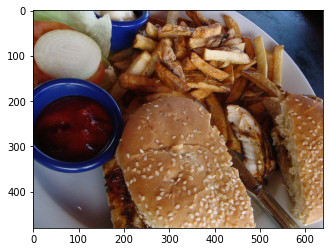

A plate of food which includes onions, tomato, lettuce, sauce, fries, and a sandwich.
A sandwich, french fries, bowl of ketchup, onion slice, lettuce slice, tomato slice, and knife sit on the white plate.
Partially eaten hamburger on a plate with fries and condiments. 
A grilled chicken sandwich sits beside french fries made with real potatoes. 
A sandwich on a sesame seed bun next to a pile of french fries and a cup of ketchup.
[CLS] A plate of food with a fork and a fork. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


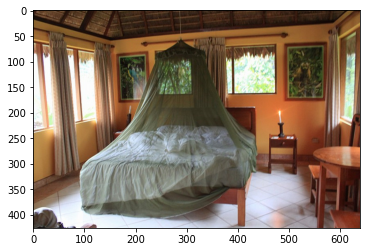

A green netted bed in a light filled bedroom.
Bed covered in mosquito netting in a bedroom with windows on three walls.
A bed in a hut covered in a bug net.
A bed with lots of pillows and blankets under a canopy.
Bed in room with candles covered by a mosquito net
[CLS] A kitchen with a stove, microwave, and a microwave microwave. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


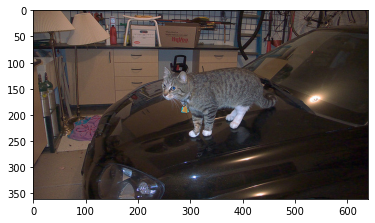

A gray cat standing on top of a black car.
A cat standing on the hood of a car.
Grey color cat standing on hood of car in garage
A gray cat on the hood of a black car
A cat sitting on the hood of a parked black car in a garage.
[CLS] A man is sitting on a bench in a room. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


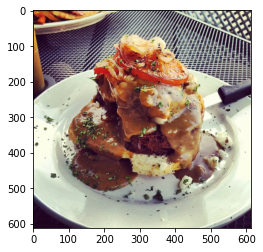

a plate of meat topped with potatoes veggies and gravy
A white plate with a pile of food on it.
A large pile of food on a plate with knife.
A white plate sitting on a table filled with food. 
Plate of food with gravy on mesh table with knife
[CLS] A plate of food with a fork and a fork. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


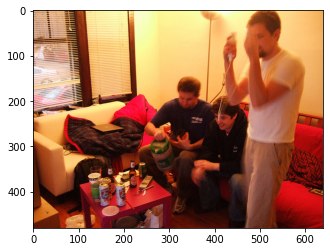

A man standing in a living room holding a Nintendo Wii game controller.
Three people with cups on the couch and one with remote standing
A man holding a motion controlled video game controller
Man with video game controller in living room with onlooker seated nearby.
A man playing a video game while two men sit on a couch. 
[CLS] A group of people standing in a living room playing a video game game game game game. [PAD]


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms as T


base_imag = 100
for j in range(base_imag,base_imag+5):
    img_test, label_test = test_data[j]

    max_output_tokens = 20
    label_init = [101]+[0]*(max_output_tokens-1)

    plt.imshow(img_test)
    plt.show()
    for label in label_test:
      print(label)

    img_test = transform_image(img_test)

    model.eval()

    idx = 0
    for i in range(1,max_output_tokens):
        if label_init[i-1]==119:
            idx = i
            break
        if i>11:
            label_truc = label_init[-max_seq_length:]
            id = max_seq_length-1
        else:
            label_truc = label_init[:max_seq_length]
            id = i-1
        logits = model(img_test.unsqueeze(dim=0).to(device),torch.LongTensor([label_truc]).to(device))

        logits = logits[:,id, :]
        predicted_id = torch.argmax(logits).item()
        label_init[i]=predicted_id
        prompt = tokenizer.decode(label_init[:i+1])
        # print(prompt)
    # print(tokenizer.decode(label_init[:idx]))
    print(tokenizer.decode(label_init))
